2025-02-12 19:07:34.823192: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 19:07:34.862237: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 19:07:34.893628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739387254.941346  187129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739387254.953106  187129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 19:07:35.088504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

MNIST Training Set: 60000 samples
MNIST Test Set: 10000 samples


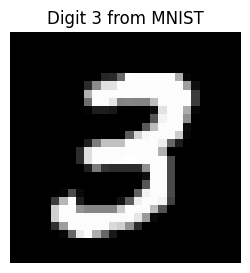


Processing Handwritten Digits Dataset (not in MNIST) from: data/handwritten-digits-not-mnist/dataset
Processing 10773 samples for digit 0
Processing 10773 samples for digit 1
Processing 10773 samples for digit 2
Processing 10773 samples for digit 3
Processing 10773 samples for digit 4
Processing 10773 samples for digit 5
Processing 10773 samples for digit 6
Processing 10773 samples for digit 7
Processing 10773 samples for digit 8
Processing 10773 samples for digit 9


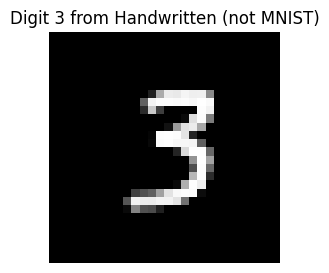

Loading EMNIST data from: data/emnist/emnist-digits-train.csv


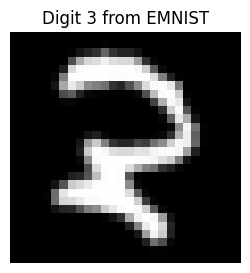

Loading USPS data from data/usps/usps.h5
Resizing USPS images from 16x16 to 28x28...


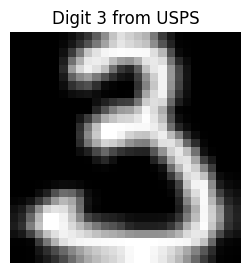


Total combined samples: 415020

After splitting:
Training samples: 373518
Validation samples: 41502

Original Datasets:
----------------------------------------
MNIST Train                    :   60,000 samples
MNIST Test                     :   10,000 samples
Handwritten Digits (not MNIST) :  107,730 samples
EMNIST                         :  239,999 samples
USPS                           :    7,291 samples

Combined Dataset:
----------------------------------------
Total Combined                 :  415,020 samples

After Train/Val Split:
----------------------------------------
Training Set                   :  373,518 samples
Validation Set                 :   41,502 samples

Applying Elastic Transform to entire training set (offline) ...


/tmp/ipykernel_187129/883217011.py:288: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=50, sigma=5, alpha_affine=50, p=1.0)


Original training size: 373518 | After augmentation: 747036

After augmentation (per epoch):
Original training samples (now doubled): 747036
Augmented samples per epoch: 747008


/home/maruf/.cache/pypoetry/virtualenvs/pattern-recognition-neural-network-coursew-8OHAYx0u-py3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-12 19:12:14.173166: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/maruf/.cache/pypoetry/virtualenvs/pattern-recognition-neural-network-coursew-8OHAYx0u-py3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these argumen

Epoch 1/5
2919/2919 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8736 - loss: 1.2265

In [ ]:
import os

import numpy as np
import tensorflow as tf
from kaggle.api.kaggle_api_extended import KaggleApi
from kagglehub import KaggleDatasetAdapter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, MaxPool2D,
                                     SpatialDropout2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# ========== NEW IMPORTS FOR ELASTIC TRANSFORM ==========
import albumentations as A
import cv2
# ========================================================

# Create consistent directory structure
BASE_DATA_DIR = 'data'
DATASETS: dict[str, str] = {
    'mnist': os.path.join(BASE_DATA_DIR, 'mnist'),
    'emnist': os.path.join(BASE_DATA_DIR, 'emnist'),
    'handwritten_digits': os.path.join(BASE_DATA_DIR, 'handwritten-digits-not-mnist'),
    'usps': os.path.join(BASE_DATA_DIR, 'usps'),
    'models': os.path.join(BASE_DATA_DIR, 'models')
}

# Create all necessary directories
for directory in DATASETS.values():
    os.makedirs(directory, exist_ok=True)

def print_dataset_summary(dataset_name, count):
    print(f"{dataset_name:<30} : {count:>8,d} samples")
    

def print_class_distribution(labels, dataset_name):
    """Print distribution of classes in a dataset"""
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{dataset_name} class distribution:")
    for digit, count in zip(unique, counts):
        print(f"Digit {digit}: {count} samples")
    print(f"Total samples: {len(labels)}")


def print_total_samples(labels, dataset_name):
    """Print only total samples in a dataset"""
    print(f"{dataset_name}: {len(labels)} samples")

def show_digit_3(images, labels, dataset_name):
    """Display first occurrence of digit 3 in dataset"""
    idx = np.where(labels == 3)[0][0]
    plt.figure(figsize=(3, 3))
    plt.imshow(images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Digit 3 from {dataset_name}')
    plt.axis('off')
    plt.show()

def load_mnist_data():
    """Load and process MNIST dataset."""
    (x_train, labels_train), (x_test, labels_test) = mnist.load_data()
    print_total_samples(labels_train, "MNIST Training Set")
    print_total_samples(labels_test, "MNIST Test Set")
    
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Visualize digit 3
    show_digit_3(x_train, labels_train, "MNIST")
    
    return x_train, labels_train, x_test, labels_test

def load_handwritten_digits():
    """Load and process Handwritten Digits Dataset (not in MNIST) from a local directory."""
    images = []
    labels = []
    dataset_path = os.path.join(DATASETS['handwritten_digits'], 'dataset')
    
    print(f"\nProcessing Handwritten Digits Dataset (not in MNIST) from: {dataset_path}")
    
    for label in range(10):
        folder_path = os.path.join(dataset_path, str(label), str(label))
        if not os.path.exists(folder_path):
            print(f"Warning: Missing directory for label {label} - {folder_path}")
            continue
            
        file_count = len([name for name in os.listdir(folder_path) if name.endswith('.png')])
        print(f"Processing {file_count} samples for digit {label}")
        
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                img_path = os.path.join(folder_path, filename)
                try:
                    # Flatten alpha onto white, then convert to grayscale
                    with Image.open(img_path).convert("RGBA") as rgba_img:
                        # Create a white background the same size as the image
                        bg = Image.new("RGBA", rgba_img.size, (255, 255, 255, 255))
                        bg.paste(rgba_img, (0, 0), rgba_img)
                        # Convert the flattened image to grayscale
                        img = bg.convert('L')
                    
                    # Resize to 28x28
                    img = img.resize((28, 28))
                    
                    # Convert to NumPy array and scale the pixel values
                    img_array = np.array(img).astype('float32') / 255.0
                    # Invert colors to get white digits on a black background
                    img_array = 1.0 - img_array
                    
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
                    continue
                
    images = np.array(images)
    labels = np.array(labels)
    
    # Visualize digit 3
    show_digit_3(images, labels, "Handwritten (not MNIST)")
    
    return images, labels

def load_emnist_data():
    """Load and process EMNIST digits dataset from local directory."""
    train_file = os.path.join(DATASETS['emnist'], 'emnist-digits-train.csv')
    
    try:
        if not os.path.exists(train_file):
            print(f"Error: EMNIST data file not found at {train_file}")
            print("\nAvailable files in EMNIST directory:")
            for file in os.listdir(DATASETS['emnist']):
                print(f"- {file}")
            raise FileNotFoundError(f"EMNIST data file not found at {train_file}")
        
        print(f"Loading EMNIST data from: {train_file}")
        
        import pandas as pd
        data = pd.read_csv(train_file)
        
        if data.empty:
            raise ValueError("Loaded CSV file is empty")
        
        labels = data.iloc[:, 0].values
        pixels = data.iloc[:, 1:].values
        
        images = pixels.reshape(-1, 28, 28)
        images = images.transpose(0, 2, 1)
        images = np.flip(images, axis=1)
        
        images = images.astype('float32') / 255.0
        
        # Visualize digit 3
        show_digit_3(images, labels, "EMNIST")
        
        return images, labels
        
    except Exception as e:
        print(f"Error loading EMNIST data: {str(e)}")
        return None, None

def load_usps_data():
    """Load and process USPS dataset from local file."""
    import h5py
    usps_path = os.path.join(DATASETS['usps'], 'usps.h5')
    
    if not os.path.exists(usps_path):
        raise FileNotFoundError(f"USPS dataset file not found at {usps_path}")
        
    print(f"Loading USPS data from {usps_path}")
    
    with h5py.File(usps_path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
    
    from skimage.transform import resize
    print("Resizing USPS images from 16x16 to 28x28...")
    resized_images = []
    for img in X_train:
        img = img.reshape(16, 16)
        img_resized = resize(img, (28, 28), anti_aliasing=True)
        resized_images.append(img_resized)
    
    images = np.array(resized_images)
    images = images.astype('float32')
    if images.max() > 1.0:
        images /= 255.0
    
    # Visualize digit 3
    show_digit_3(images, y_train, "USPS")
    
    return images, y_train

def prepare_data():
    """Prepare and combine all datasets."""
    # Load MNIST
    x_train_mnist, labels_train_mnist, x_test, labels_test = load_mnist_data()
    x_train_mnist = x_train_mnist.reshape(-1, 28, 28, 1)
    y_train_mnist = tf.keras.utils.to_categorical(labels_train_mnist, 10)
    
    # Load handwritten digits data
    handwritten_images, handwritten_labels = load_handwritten_digits()
    handwritten_images = handwritten_images.reshape(-1, 28, 28, 1)
    handwritten_labels_cat = tf.keras.utils.to_categorical(handwritten_labels, 10)
    
    # Load EMNIST
    emnist_images, emnist_labels = load_emnist_data()
    emnist_images = emnist_images.reshape(-1, 28, 28, 1)
    emnist_labels_cat = tf.keras.utils.to_categorical(emnist_labels, 10)
    
    # Load USPS
    usps_images, usps_labels = load_usps_data()
    usps_images = usps_images.reshape(-1, 28, 28, 1)
    usps_labels_cat = tf.keras.utils.to_categorical(usps_labels, 10)
    
    # Combine datasets
    x_train_combined = np.concatenate([
        x_train_mnist, 
        handwritten_images, 
        emnist_images, 
        usps_images
    ])
    y_train_combined = np.concatenate([
        y_train_mnist, 
        handwritten_labels_cat, 
        emnist_labels_cat, 
        usps_labels_cat
    ])
    
    print(f"\nTotal combined samples: {len(x_train_combined)}")
    
    # Shuffle and split
    x_train_combined, y_train_combined = shuffle(
        x_train_combined, 
        y_train_combined, 
        random_state=42
    )
    
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_combined, 
        y_train_combined, 
        test_size=0.1, 
        random_state=42
    )
    
    print(f"\nAfter splitting:")
    print(f"Training samples: {len(x_train)}")
    print(f"Validation samples: {len(x_val)}")
    
    print("\nOriginal Datasets:")
    print("-" * 40)
    print_dataset_summary("MNIST Train", len(labels_train_mnist))
    print_dataset_summary("MNIST Test", len(labels_test))
    print_dataset_summary("Handwritten Digits (not MNIST)", len(handwritten_labels))
    print_dataset_summary("EMNIST", len(emnist_labels))
    print_dataset_summary("USPS", len(usps_labels))
    
    # After combining
    total_samples = len(x_train_combined)
    print("\nCombined Dataset:")
    print("-" * 40)
    print_dataset_summary("Total Combined", total_samples)
    
    # After splitting
    print("\nAfter Train/Val Split:")
    print("-" * 40)
    print_dataset_summary("Training Set", len(x_train))
    print_dataset_summary("Validation Set", len(x_val))
    
    return x_train, y_train, x_val, y_val

# Prepare data
x_train, y_train, x_val, y_val = prepare_data()

# ========== NEW OFFLINE ELASTIC AUGMENTATION BLOCK ==========
# This block doubles the size of x_train by creating an elastic-transformed
# version for each sample. Adjust alpha/sigma/alpha_affine as needed.

print("\nApplying Elastic Transform to entire training set (offline) ...")
elastic_transform = A.Compose([
    A.ElasticTransform(alpha=50, sigma=5, p=1.0)
])

augmented_images = []
augmented_labels = []

# x_train shape is (N, 28, 28, 1)
# We'll convert to uint8, apply transform, then convert back.
for i in range(len(x_train)):
    # Extract single-channel image
    image_0_1 = x_train[i, :, :, 0]  # shape (28,28)
    image_255 = (image_0_1 * 255).astype(np.uint8)  # to uint8

    # Albumentations expects an HxWxC, BGR or RGB array. We'll treat it as grayscale.
    # So we can expand it to HxWx1 or just pass as HxW and interpret as grayscale.
    augmented = elastic_transform(image=image_255)
    aug_img_255 = augmented["image"]

    # Convert back to float [0,1], shape (28,28)
    aug_img_01 = aug_img_255.astype(np.float32) / 255.0
    
    # Re-expand channel dimension
    aug_img_01 = np.expand_dims(aug_img_01, axis=-1)  # shape (28,28,1)

    augmented_images.append(aug_img_01)
    augmented_labels.append(y_train[i])

augmented_images = np.array(augmented_images, dtype=np.float32)
augmented_labels = np.array(augmented_labels)

# Concatenate with original training
x_train = np.concatenate([x_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_labels], axis=0)

print(f"Original training size: {len(x_train)//2} | "
      f"After augmentation: {len(x_train)}")

# ============================================================

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

steps_per_epoch = len(x_train) // 256  # batch_size = 256
# Print augmentation info
print(f"\nAfter augmentation (per epoch):")
print(f"Original training samples (now doubled): {len(x_train)}")
print(f"Augmented samples per epoch: {steps_per_epoch * 256}")

# Model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2)),
    SpatialDropout2D(0.2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2)),
    SpatialDropout2D(0.2),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        os.path.join(DATASETS['models'], 'best_model.h5'),
        save_best_only=True,
        monitor='val_accuracy'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

# Train model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=256),
    validation_data=(x_val, y_val),
    epochs=5,
    callbacks=callbacks
)

# Save final model in HDF5 format
model.save(os.path.join(DATASETS['models'], 'final_model.h5'))
